<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/KerasNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Setups

In [20]:
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import joblib

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import scipy as sp
from scipy import stats

import joblib
import sys

In [19]:
print(tf.__version__)
print(sys.version)

2.15.0
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load and Process Data

In [12]:
path_after_2010 = '/content/gdrive/My Drive/School/Grad School/NIOSH Project/Data/violations_processed_after_2010.csv'
violation_data = pd.read_csv(path_after_2010)

<ipython-input-12-837e5d150e00>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  violation_data = pd.read_csv(path_after_2010)


In [13]:
FEATURES = ['MINE_TYPE', 'COAL_METAL_IND', 'SIG_SUB', 'LIKELIHOOD',
            'INJ_ILLNESS', 'NO_AFFECTED', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT',
            'VIOLATOR_INSPECTION_DAY_CNT']
TARGETS = ['PROPOSED_PENALTY']

X = violation_data[FEATURES]
y = violation_data[TARGETS]

In [14]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 'INJ_ILLNESS', 'SIG_SUB', 'NEGLIGENCE']
columns_to_scale  = ['VIOLATOR_VIOLATION_CNT', 'NO_AFFECTED', 'VIOLATOR_INSPECTION_DAY_CNT']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print('Features shape:', X_pre.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Features shape: (1561534, 24)


Save encoder and scaler.

In [17]:
joblib.dump(scaler, '/content/gdrive/My Drive/School/Grad School/NIOSH Project/Models/PropPenalty-NN/PropPenalty-NN-scaler.pkl')
joblib.dump(ohe, '/content/gdrive/My Drive/School/Grad School/NIOSH Project/Models/PropPenalty-NN/PropPenalty-NN-encoder.pkl')

['/content/gdrive/My Drive/School/Grad School/NIOSH Project/Models/PropPenalty-NN/PropPenalty-NN-encoder.pkl']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

X_train shape: (1171150, 24)
X_test shape: (390384, 24)
y_train shape: (1171150, 1)
y_train shape: (390384, 1)


## Neural Network Model

In [ ]:
def scheduler(epoch, lr):
  if epoch < 85:
    return lr
  else: # Drop learning rate after the first 85 epochs
    return lr*np.exp(-0.05)

In [ ]:
batch_size = 2**14
epochs = 120
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = keras.Sequential()

model.add(keras.Input(shape = (len(X_train[0]), ) ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(1, activation="linear"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=opt)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/120
71/71 [==============================] - 4s 10ms/step - loss: 11520864.0000 - val_loss: 9420368.0000 - lr: 0.0100
Epoch 2/120
71/71 [==============================] - 0s 5ms/step - loss: 8590063.0000 - val_loss: 6956679.5000 - lr: 0.0100
Epoch 3/120
71/71 [==============================] - 0s 7ms/step - loss: 6770951.5000 - val_loss: 6171946.0000 - lr: 0.0100
Epoch 4/120
71/71 [==============================] - 0s 6ms/step - loss: 6258278.5000 - val_loss: 5912135.0000 - lr: 0.0100
Epoch 5/120
71/71 [==============================] - 0s 5ms/step - loss: 6131072.5000 - val_loss: 5768830.5000 - lr: 0.0100
Epoch 6/120
71/71 [==============================] - 0s 5ms/step - loss: 6117321.5000 - val_loss: 5847908.5000 - lr: 0.0100
Epoch 7/120
71/71 [==============================] - 0s 5ms/step - loss: 6016164.0000 - val_loss: 5650781.0000 - lr: 0.0100
Epoch 8/120
71/71 [==============================] - 0s 5ms/step - loss: 5872126.5000 - val_loss: 5669874.0000 - lr: 0.0100
Epoch 

In [ ]:
model.save('/content/gdrive/My Drive/School/Grad School/NIOSH Project/Models/PropPenalty-NN/PropPenalty-NN.keras')

In [38]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/School/Grad School/NIOSH Project/Models/PropPenalty-NN/PropPenalty-NN.keras')

OSError: Unable to open file (file signature not found)

In [35]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('r2 = %.3f' % r2)

12200/12200 [==============================] - 18s 1ms/step
r2 = 0.605


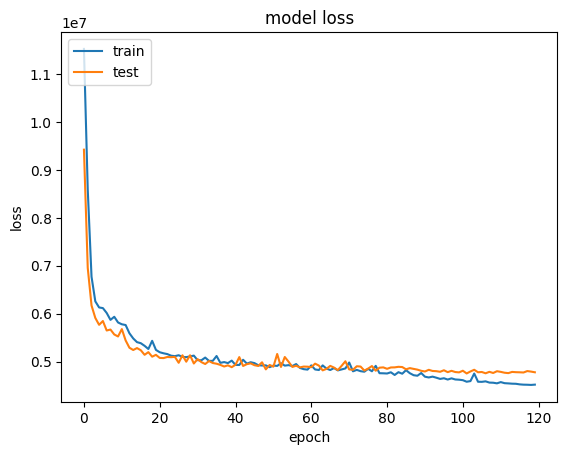

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()